In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler

In [27]:
# load dataset
df = pd.read_csv('../base/heart.csv')
print(df.columns)

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestingECG', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ST_Slope',
       'HeartDisease'],
      dtype='object')


Célula para corrigir os valores de zero

In [28]:
# Colunas com valores de zero que são clinicamente impossíveis
cols_to_correct = ["RestingBP", "Cholesterol"]

# Substituir 0 por NaN (Not a Number) para que possamos calcular a mediana corretamente
for col in cols_to_correct:
    df[col] = df[col].replace(0, np.nan)

# Calcular a mediana de cada coluna (ignorando os NaN) e preencher os valores faltantes
for col in cols_to_correct:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# Verificar se ainda existem valores nulos ou zeros nessas colunas
print("Valores nulos após a correção:")
print(df[cols_to_correct].isnull().sum())
print("\nNovas estatísticas descritivas:")
print(df[cols_to_correct].describe())

Valores nulos após a correção:
RestingBP      0
Cholesterol    0
dtype: int64

Novas estatísticas descritivas:
        RestingBP  Cholesterol
count  918.000000   918.000000
mean   132.538126   243.204793
std     17.990127    53.401297
min     80.000000    85.000000
25%    120.000000   214.000000
50%    130.000000   237.000000
75%    140.000000   267.000000
max    200.000000   603.000000


## Explorar os dados (EDA - Análise Exploratória)

In [29]:
df.head()
# Checar valores ausentes
print(df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


### Estatísticas Descritivas:

In [30]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.538126,243.204793,0.233115,136.809368,0.887364,0.553377
std,9.432617,17.990127,53.401297,0.423046,25.460334,1.066570,0.497414
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,237.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [31]:
# Checar valores ausentes
print(df.isnull().sum())

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64


### Histogramas

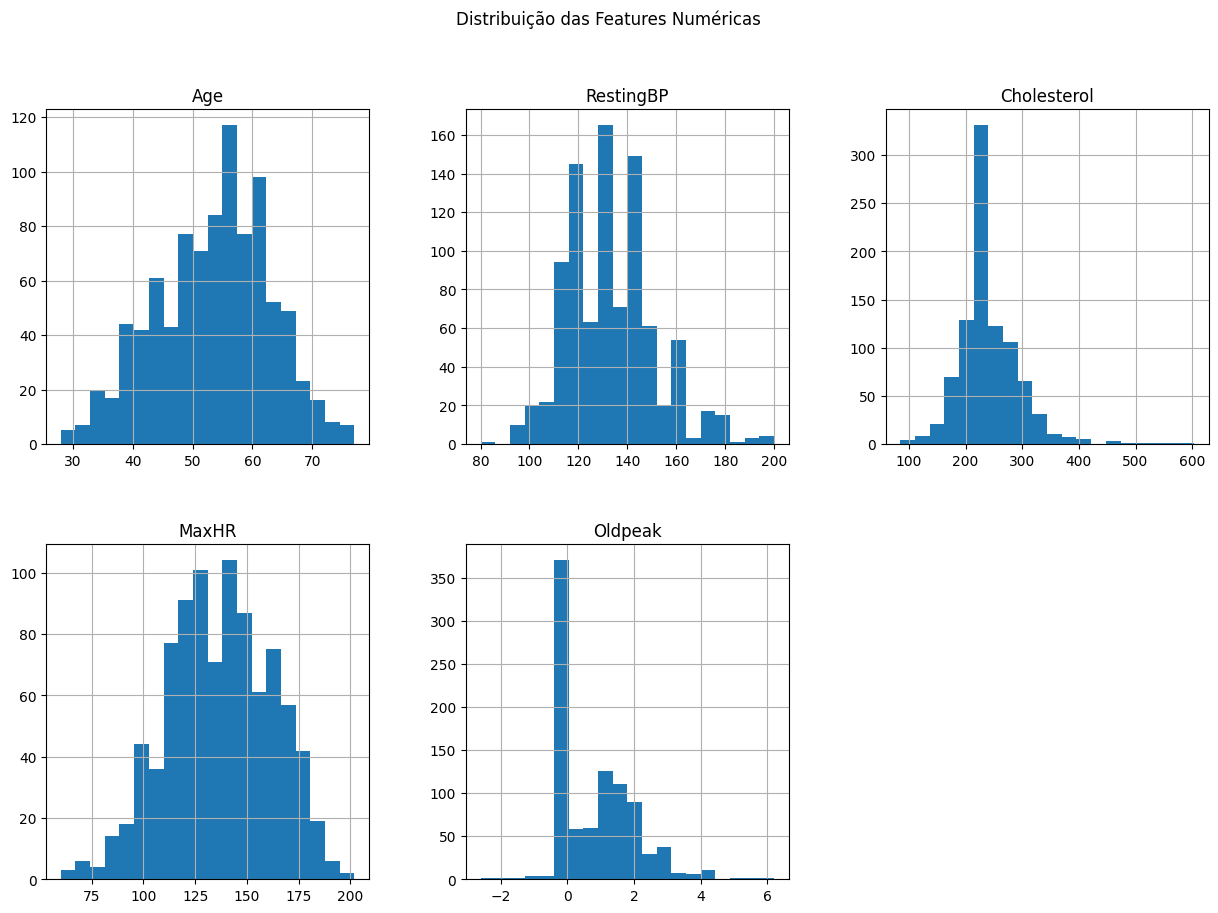

In [32]:
# Seleciona as colunas que parecem ser numéricas
numerical_features = ["Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak"]

# Cria um histograma para cada feature numérica
df[numerical_features].hist(bins=20, figsize=(15, 10), layout=(2, 3))
plt.suptitle("Distribuição das Features Numéricas")
plt.show()

### Visualização de Features Categóricas (Gráficos de Contagem)

In [33]:
# Seleciona as colunas que parecem ser categóricas (incluindo a variável alvo para análise)
categorical_features = [
    "Sex",
    "ChestPainType",
    "FastingBS",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope",
    "HeartDisease",
]

### Cria um gráfico de contagem para cada feature categórica

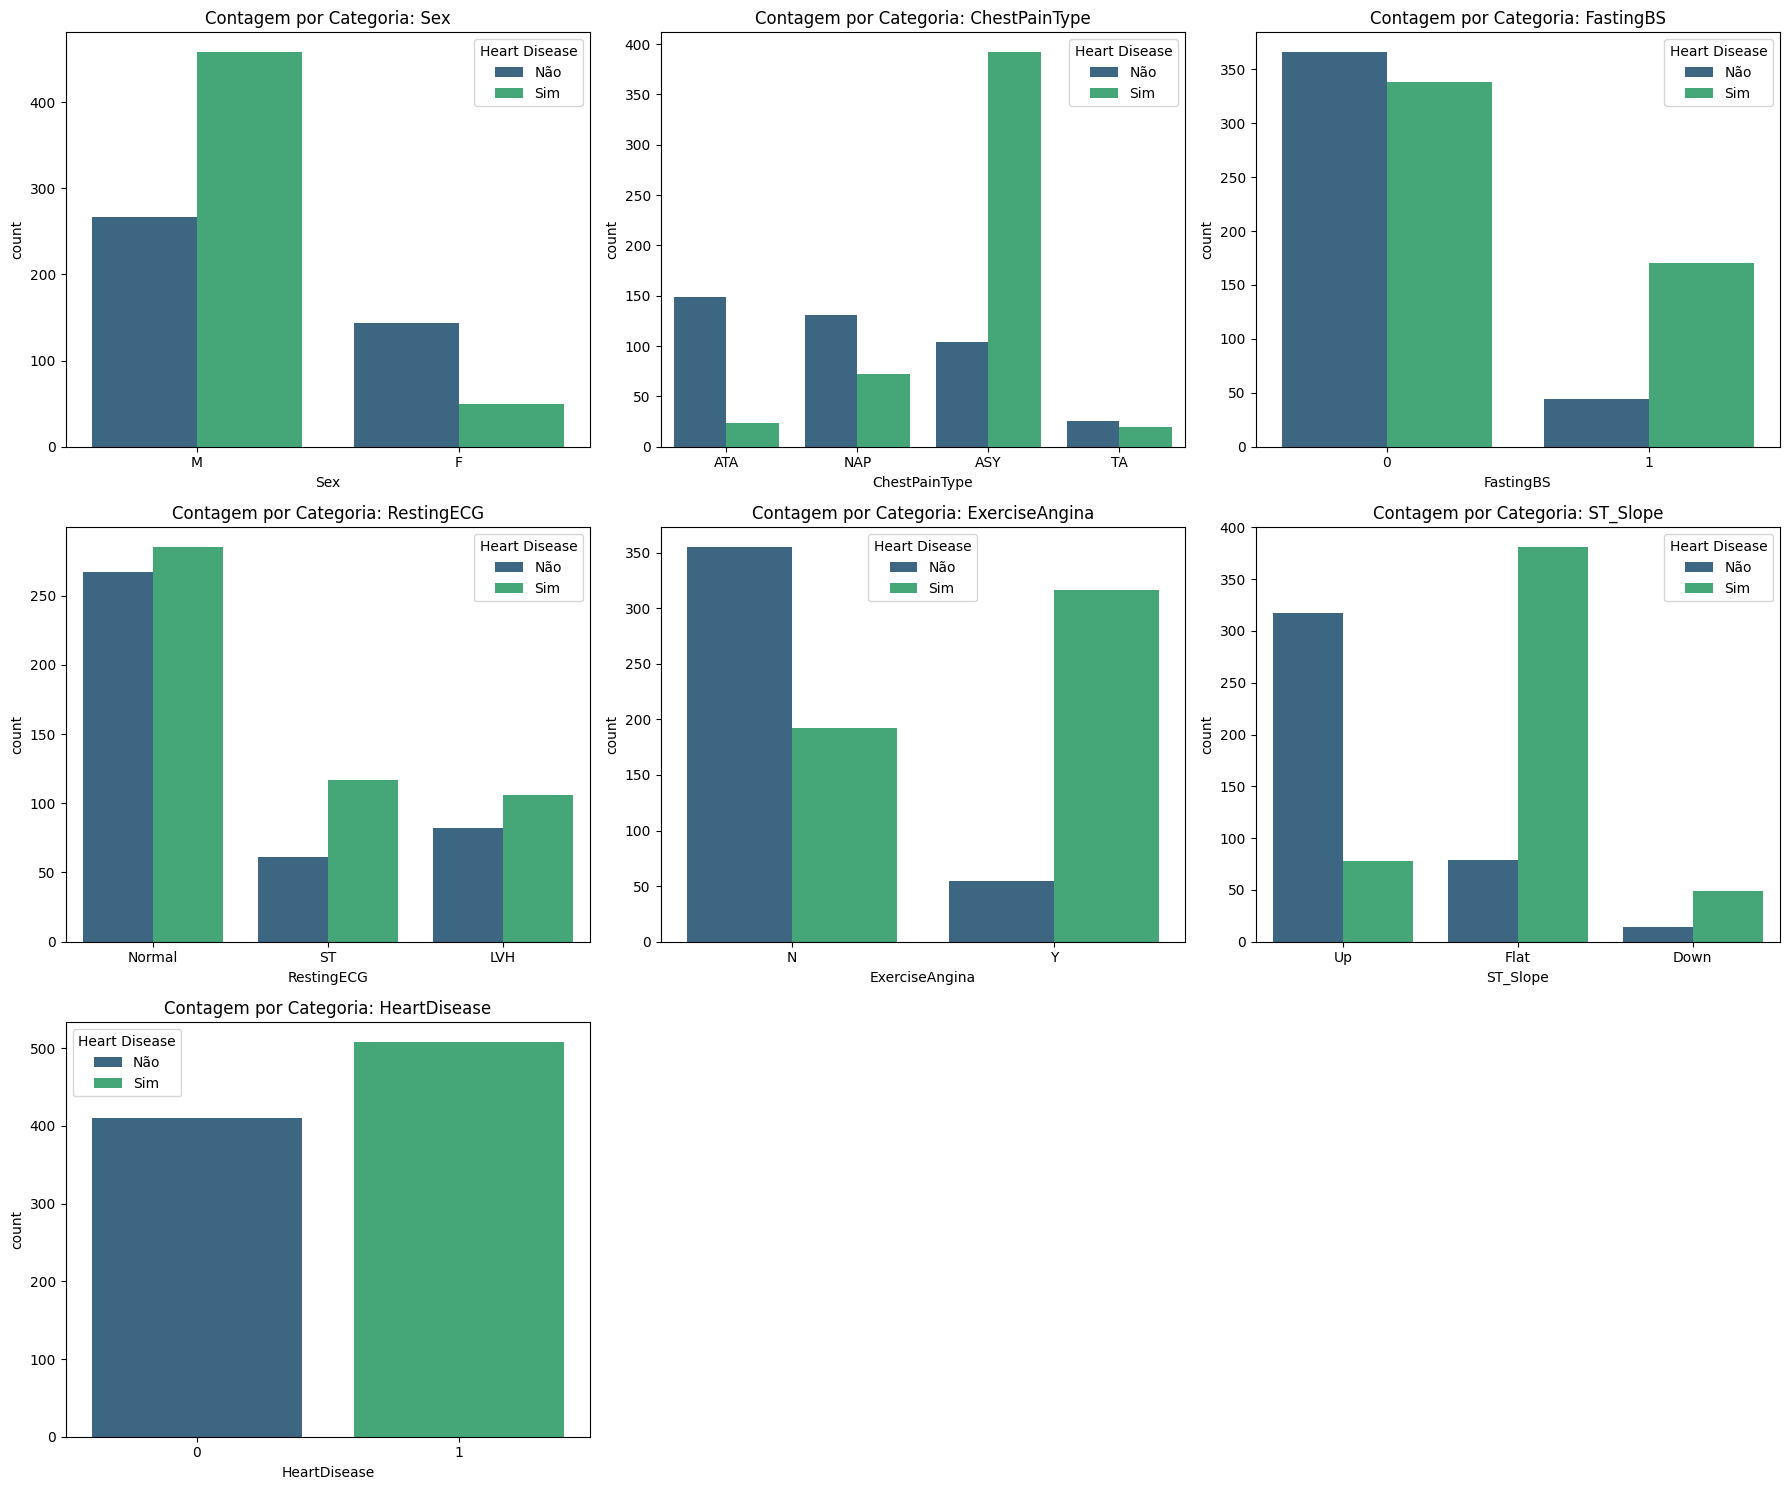

In [34]:
plt.figure(figsize=(18, 15))
for i, feature in enumerate(categorical_features):
    plt.subplot(3, 3, i + 1)  # Cria uma grade de plots
    sns.countplot(x=feature, data=df, hue="HeartDisease", palette="viridis")
    plt.title(f"Contagem por Categoria: {feature}")
    plt.legend(title="Heart Disease", labels=["Não", "Sim"])

plt.tight_layout()
plt.show()

<Axes: >

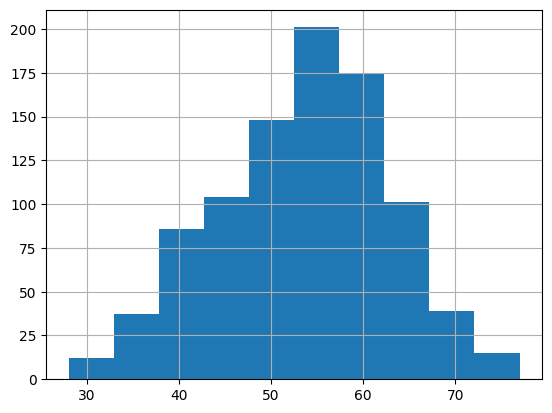

In [35]:
df["Age"].hist()

<Axes: xlabel='Sex', ylabel='count'>

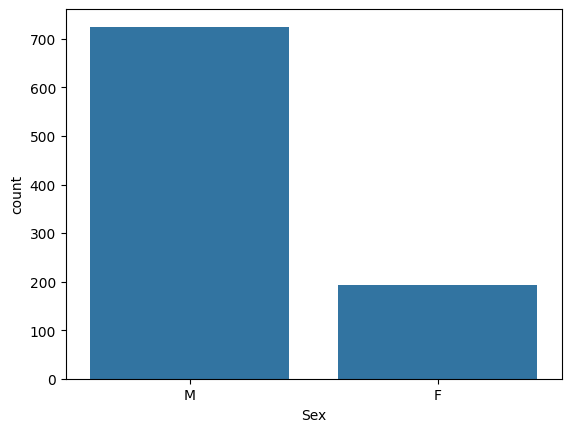

In [36]:
sns.countplot(x="Sex", data=df)

## Etapa 1: Aplicar o One-Hot Encoding

In [37]:
# Primeiro, identificamos as colunas que são realmente categóricas
# Note que não incluímos a variável alvo 'HeartDisease'
categorical_features = [
    "Sex",
    "ChestPainType",
    "FastingBS",
    "RestingECG",
    "ExerciseAngina",
    "ST_Slope",
]

# Usamos pd.get_dummies para criar as novas colunas
# drop_first=True: Remove a primeira categoria de cada feature. Isso evita redundância (multicolinearidade).
# dtype=int: Cria as novas colunas com 0s e 1s em vez de True/False.
df_encoded = pd.get_dummies(
    df, columns=categorical_features, drop_first=True, dtype=int
)

# Vamos ver como ficou o novo DataFrame com as colunas transformadas
print("Colunas do DataFrame após o One-Hot Encoding:")
print(df_encoded.columns)
print("\nPrimeiras linhas do novo DataFrame:")
print(df_encoded.head())

Colunas do DataFrame após o One-Hot Encoding:
Index(['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'HeartDisease',
       'Sex_M', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA',
       'FastingBS_1', 'RestingECG_Normal', 'RestingECG_ST', 'ExerciseAngina_Y',
       'ST_Slope_Flat', 'ST_Slope_Up'],
      dtype='object')

Primeiras linhas do novo DataFrame:
   Age  RestingBP  Cholesterol  MaxHR  Oldpeak  HeartDisease  Sex_M  \
0   40      140.0        289.0    172      0.0             0      1   
1   49      160.0        180.0    156      1.0             1      0   
2   37      130.0        283.0     98      0.0             0      1   
3   48      138.0        214.0    108      1.5             1      0   
4   54      150.0        195.0    122      0.0             0      1   

   ChestPainType_ATA  ChestPainType_NAP  ChestPainType_TA  FastingBS_1  \
0                  1                  0                 0            0   
1                  0                  1     

### Etapa 2: Nova Seleção de Recursos e Divisão
Seleção de recurso

- Variáveis independentes (features):
São as colunas que você usa como base para prever a target.

- Variável dependente (target):
A variável que você quer prever — neste caso, se a pessoa tem ou não doença cardíaca

In [38]:
# Agora, separamos X e y a partir deste NOVO DataFrame codificado
X = df_encoded.drop("HeartDisease", axis=1)  # remove a coluna target, fica só com as features
y = df_encoded["HeartDisease"]  # pega só a coluna target para prever

# O restante do processo continua igual!
# Dividimos os novos X e y em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=16
)

# Aplicamos a padronização
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test), columns=X_test.columns, index=X_test.index
)

## Busca de Hiperparâmetros com Validação Cruzada 

In [39]:
# 1. Defina a grade de parâmetros que você quer testar
param_grid = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1, 10, 100],
    "solver": ["liblinear"],  # 'liblinear' é compatível com as penalidades l1 e l2
}

# 2. Crie o objeto GridSearchCV
#    - estimator: seu modelo base
#    - param_grid: a grade de parâmetros
#    - scoring: a métrica que o projeto pede (ex: 'f1_weighted' ou 'balanced_accuracy')
#    - cv: o número de folds da validação cruzada
grid_search = GridSearchCV(
    estimator=LogisticRegression(random_state=16, max_iter=1000),
    param_grid=param_grid,
    scoring="f1_weighted",  # ou 'balanced_accuracy'
    cv=5,
    n_jobs=-1,  # Usa todos os processadores disponíveis para acelerar
)

# 3. Treine o GridSearchCV com os dados de treino já padronizados
# Lembre-se que X_train_scaled e y_train vêm da sua etapa de train_test_split
grid_search.fit(X_train_scaled, y_train)

# 4. Veja os melhores parâmetros encontrados
print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

Melhores parâmetros encontrados: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


## Usaremos o melhor modelo encontrado pelo GridSearchCV

In [40]:
print(f"Usando o modelo com os parâmetros: {best_model.get_params()}")

# Métrica a ser usada na validação cruzada
# Opções: 'f1_weighted' ou 'balanced_accuracy'
METRICA_ESCOLHIDA = "balanced_accuracy"

metric_scores_means = [] # Lista para guardar a média de cada uma das 30 execuções

N_REPETICOES = 30

for i in range(N_REPETICOES):
    # 1. Divida os dados com um random_state diferente a cada iteração
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=i
    )

    # 2. Padronize os dados DENTRO do loop para evitar data leakage
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # 3. Execute a validação cruzada com 5 folds
    #  A função retorna um array com 5 scores (um para cada fold)
    scores = cross_val_score(
        estimator=best_model,
        X=X_train_scaled,
        y=y_train,
        cv=5,
        scoring=METRICA_ESCOLHIDA,
    )

    # 4. Calcule a média dos 5 scores e guarde na lista
    metric_scores_means.append(scores.mean())
    print(
        f"Execução {i + 1}/{N_REPETICOES} | Média da {METRICA_ESCOLHIDA}: {scores.mean():.4f}"
    )

# Ao final do loop, teremos 30 médias de scores
mean_of_means = np.mean(metric_scores_means)
std_of_means = np.std(metric_scores_means)

print("\n" + "=" * 50)
print("Resultado Final após 30 Execuções da Validação Cruzada 5-Fold")
print("=" * 50)
print(f"Métrica utilizada: {METRICA_ESCOLHIDA}")
print(f"Média das médias dos scores: {mean_of_means:.4f}")
print(f"Desvio padrão das médias dos scores: {std_of_means:.4f}")
print("=" * 50)

Usando o modelo com os parâmetros: {'C': 0.1, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 1000, 'multi_class': 'deprecated', 'n_jobs': None, 'penalty': 'l2', 'random_state': 16, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Execução 1/30 | Média da balanced_accuracy: 0.8639
Execução 2/30 | Média da balanced_accuracy: 0.8460
Execução 3/30 | Média da balanced_accuracy: 0.8487
Execução 4/30 | Média da balanced_accuracy: 0.8487
Execução 5/30 | Média da balanced_accuracy: 0.8445
Execução 6/30 | Média da balanced_accuracy: 0.8390
Execução 7/30 | Média da balanced_accuracy: 0.8527
Execução 8/30 | Média da balanced_accuracy: 0.8518
Execução 9/30 | Média da balanced_accuracy: 0.8496
Execução 10/30 | Média da balanced_accuracy: 0.8485
Execução 11/30 | Média da balanced_accuracy: 0.8584
Execução 12/30 | Média da balanced_accuracy: 0.8669
Execução 13/30 | Média da balanced_accuracy: 0.8545
Execução 14/

## Desenvolvimento e previsão de modelos

In [41]:
# instancia o modelo (usando os parâmetros padrão)
logreg = best_model.fit(X_train_scaled, y_train)

# ajuste o modelo com dados
logreg.fit(X_train_scaled, y_train)

y_pred = best_model.predict(X_test_scaled)

Análise dos Coeficientes do Modelo (Explicabilidade):
A Regressão Logística permite ver quais features mais influenciaram a previsão.

In [42]:
# Cria um DataFrame com os nomes das features e seus coeficientes
coefficients = pd.DataFrame(logreg.coef_[0], X.columns, columns=["Coefficient"])

# Ordena os coeficientes para ver os mais importantes (positiva ou negativamente)
print("Features mais importantes para o modelo:")
print(coefficients.sort_values("Coefficient", ascending=False))

Features mais importantes para o modelo:
                   Coefficient
Sex_M                 0.538748
ST_Slope_Flat         0.499387
FastingBS_1           0.449194
Oldpeak               0.373378
ExerciseAngina_Y      0.368846
Age                   0.182964
RestingBP             0.059193
Cholesterol           0.031405
RestingECG_Normal    -0.044104
RestingECG_ST        -0.083194
ChestPainType_TA     -0.200159
MaxHR                -0.221127
ST_Slope_Up          -0.571863
ChestPainType_ATA    -0.589696
ChestPainType_NAP    -0.635343


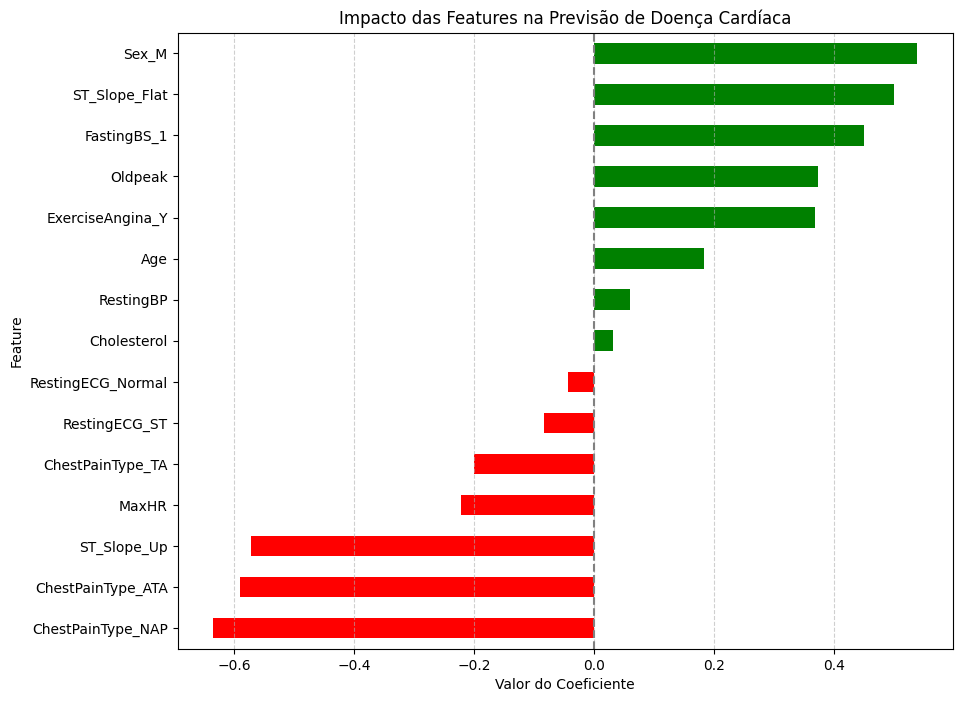

In [43]:
# Ordena os coeficientes para melhor visualização no gráfico
sorted_coefficients = coefficients.sort_values("Coefficient")

# Cria o gráfico de barras horizontais
plt.figure(figsize=(10, 8))
sorted_coefficients["Coefficient"].plot(
    kind="barh",
    color=sorted_coefficients["Coefficient"].apply(lambda x: "g" if x > 0 else "r"),
)
plt.title("Impacto das Features na Previsão de Doença Cardíaca")
plt.xlabel("Valor do Coeficiente")
plt.ylabel("Feature")
plt.axvline(
    x=0, color="grey", linestyle="--"
)  # Adiciona uma linha no zero para referência
plt.grid(axis="x", linestyle="--", alpha=0.6)
plt.show()

Calcula a acurácia balanceada

In [44]:
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"Acurácia: {logreg.score(X_test_scaled, y_test):.4f}")
print(f"Acurácia Balanceada: {balanced_acc:.4f}")
print(
    f"F1-Score (Ponderado): {metrics.f1_score(y_test, y_pred, average='weighted'):.4f}"
)

Acurácia: 0.8522
Acurácia Balanceada: 0.8516
F1-Score (Ponderado): 0.8521


In [45]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[ 93,  19],
       [ 15, 103]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted label')

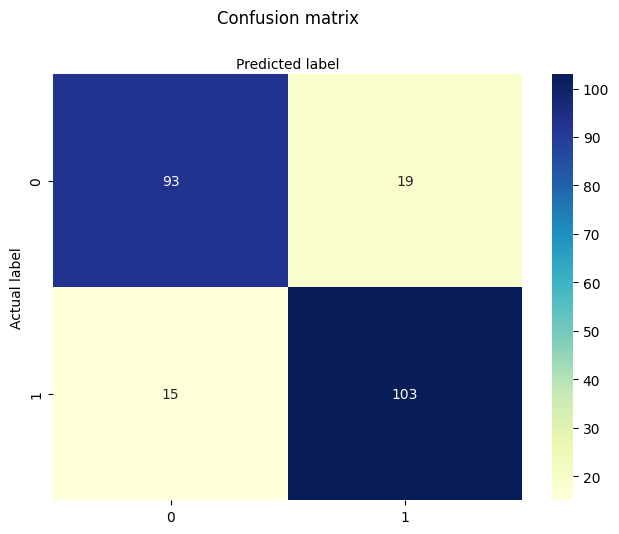

In [46]:
class_names = [0, 1]  # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu", fmt="g")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual label")
plt.xlabel("Predicted label")

### Métricas de avaliação da matriz de confusão

In [47]:
target_names = ["Without HeartDisease", "With HeartDisease"]
print(classification_report(y_test, y_pred, target_names=target_names))

                      precision    recall  f1-score   support

Without HeartDisease       0.86      0.83      0.85       112
   With HeartDisease       0.84      0.87      0.86       118

            accuracy                           0.85       230
           macro avg       0.85      0.85      0.85       230
        weighted avg       0.85      0.85      0.85       230



## Curva ROC
A curva ROC (Receiver Operating Characteristic, característica operacional do receptor) é um gráfico da taxa de verdadeiros positivos em relação à taxa de falsos positivos. Ele mostra a troca entre sensibilidade e especificidade.

A pontuação AUC para o caso é de 0,91. A pontuação AUC 1 representa um classificador perfeito, e 0,5 representa um classificador inútil.

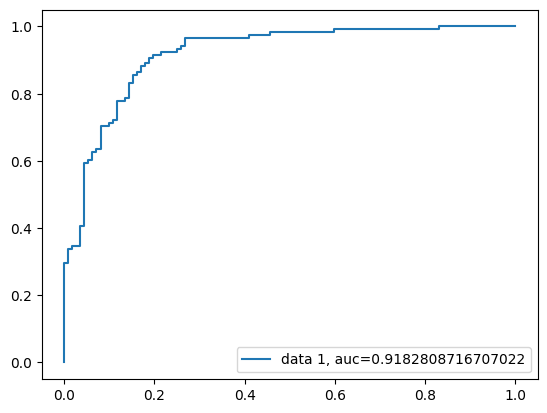

In [48]:
y_pred_proba = logreg.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
dados = {"name_model":"Logistic Regresion","fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc_auc": float(auc)},
import json
path = '../roc_auc_data.json'
with open(path, "r", encoding="utf-8") as f:
    read_data = json.load(f)

read_data["lr_roc_auc"] = dados

with open(path, "w", encoding="utf-8") as f:
    json.dump(read_data, f, indent=4, ensure_ascii=False)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()